In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         # Modules to see files and folders in directories
from os.path import dirname as parent_folder
# plt.close('all')

In [2]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
r = np.random             # Random generator
r.seed(42)                # Set a random (but fixed) seed

font_size = 10

In [5]:
Verbose = False
Saveplots = True

In [6]:
IncludeSignalInData = True
IncludeSignalInFit = True
#IncludeSignalInData = False
#IncludeSignalInFit = False

In [7]:
## Set som plotting standards:
#font = {'family' : 'serif',
#        'weight' : 'normal',
#        'size'   : 18}
#mpl.rc('font', **font)

In [8]:
#verbose = True
#Nverbose = 10
#SaveFigures = False

In [9]:
# ----------------------------------------------------------------------------------- #
#
#  Script for reading data for the Applied Statistics problem on "Gamma Spectrum".
#
#  Author: Troels C. Petersen (NBI)
#  Email:  petersen@nbi.dk
#  Date:   1st of December 2019
# ----------------------------------------------------------------------------------- #


from array import array
import numpy as np

# ----------------------------------------------------------------------------------- #
# Read data (channel numbers):
# ----------------------------------------------------------------------------------- #

x_data = []

with open( 'data_GammaSpectrum.txt', 'r' ) as infile :
    for line in infile:
        line = line.strip().split()
        x_data.append(float(line[0]))

        # Print the first 10 numbers as a sanity check:
        if (len(x_data) < 10) :
            print(x_data[-1])

x_data = np.array(x_data)
print("The number of entries in the file was: ", len(x_data))

121.3441
144.7034
71.8433
156.3025
60.444
88.5003
412.0807
182.3491
388.7483
The number of entries in the file was:  47173


In [10]:
# Histogram specifications:
xmin =   0.0
xmax = 1000 #200.0
Nbins =  2000       # Note that this gives the bins a natural width, and is much smaller than sigma of the signal!
binwidth = (xmax-xmin) / Nbins
binwidth

0.5

# ---
## CASE: Gaussian distribution on an exponential background:
 * $signal(x) = \frac{N_{sig}}{\sigma \sqrt{2\pi}} \cdot \exp{\left [-0.5 \cdot (\frac{x-\mu}{\sigma})^{2}\right]}$ for $x$ in [0,1000]
 
 * $bkg(x) = N_{bkg} \cdot  c \cdot \exp{[-cx]}$                   for $x$ in [0,1000]
---

In [11]:
# Normalized Gaussian:
def gauss_pdf(x, mu, sigma):
    # return np.exp(-(x - mu)**2 / 2.0 / sigma**2)
    return 1.0 / np.sqrt(2 * np.pi) / np.abs(sigma) * np.exp(-(x - mu)**2 / 2.0 / sigma**2)

In [12]:
# Normalized Exponential:
def exponential_pdf(x, tau):
    # return np.exp(-x/tau)
    return 1.0 / tau * np.exp(-x/tau)

In [13]:
if IncludeSignalInData:
    # Produce signal (Gaussian peak):
    #Nsigx=#60#3*50
    Nsigx1  =  290#47173*1/100#100#22220#2702.702703*0.074
    mux1    = 113#122.0
    # mux    = r.uniform(10.0, 190.0)    # For signal peak of unknown position
    mux_init1 = mux1                       # Initial value to use for the peak position in fit
    sigmax1 =   1#3.0                       # This is normally not really known either!
    Nsigx2  =  1000#47173*2/100#100#12220#2702.702703*0.193
    mux2    = 137#155.0
    # mux    = r.uniform(10.0, 190.0)    # For signal peak of unknown position
    mux_init2 = mux2                       # Initial value to use for the peak position in fit
    sigmax2 =   1#3.0                       # This is normally not really known either!
    Nsigx3  =  3000#47173*2/100#47173*2/100#100#51220#2702.702703*0.376
    mux3    = 163#172.0
    # mux    = r.uniform(10.0, 190.0)    # For signal peak of unknown position
    mux_init3 = mux3                       # Initial value to use for the peak position in fit
    sigmax3 =   1#3.0                       # This is normally not really known either!
    #Nsigx1=Nsigx
    #Nsigx2=Nsigx
    #Nsigx3=Nsigx
    
#    x_signal = r.normal(mux1, sigmax1, Nsigx) + r.normal(mux2, sigmax2, Nsigx) + r.normal(mux3, sigmax3, Nsigx)
#    if (Verbose) :
#        print("  Signal: ", x_signal)
#else:
#    x_signal = []

In [14]:
cst_init=0#-1000

In [15]:
# Produce background (here exponential):
#Nbkgx =  21000
taux  =   0.5#13824100#500.0    # "Lifetime" of background
Nbkgxh1 = 50 #47173#4053874771#2000
Nbkgxh2 = 30000 # 27491#100
muxbkg = 111#83
muxbkg_init = muxbkg
sigmaxbkg = 40#150
#x_background = r.normal(muxbkg, sigmaxbkg, Nbkgxh1) + r.exponential(taux, Nbkgxh1)
#if (Verbose) :
#    print("  Background: ", x_background)

In [16]:
if IncludeSignalInFit:
    def PDFmodel_CS(x, Nsig1,Nsig2,Nsig3, mu1,mu2,mu3, sigma1,sigma2,sigma3, Nbkg1, Nbkg2, tau, mubkg, sigbkg,cst) :  #background + signal
        return (Nbkg1 * binwidth * exponential_pdf(x, tau)) + (Nbkg2 * binwidth * gauss_pdf(x, mubkg, sigbkg))+(cst)+(Nsig1 * binwidth * gauss_pdf(x, mu1, sigma1))+ (Nsig2 * binwidth * gauss_pdf(x, mu2, sigma2)) +(Nsig3 * binwidth * gauss_pdf(x, mu3, sigma3))
    # r.normal(mux1, sigmax1, Nsigx1) + r.normal(mux2, sigmax2, Nsigx2) + r.normal(mux3, sigmax3, Nsigx3)
        
    def PDFmodel_BL(x, Nsig1,Nsig2,Nsig3, mu1,mu2,mu3, sigma1,sigma2,sigma3, Nbkg1, Nbkg2, tau, mubkg, sigbkg,cst) :  #background + signal
        return (Nbkg1 * binwidth * exponential_pdf(x, tau)) + (Nbkg2 * binwidth * gauss_pdf(x, mubkg, sigbkg))+(cst)+(Nsig1 * binwidth * gauss_pdf(x, mu1, sigma1))+ (Nsig2 * binwidth * gauss_pdf(x, mu2, sigma2)) +(Nsig3 * binwidth * gauss_pdf(x, mu3, sigma3))
#        return Nbkg * binwidth *  exponential_pdf(x, tau) + Nsig * gauss_pdf(x, mu, sigma) * binwidth
    
#    def PDFmodel_UL(x, Nsig, mu, sigma, Nbkg, tau) :
#        return Nbkg *  exponential_pdf(x, tau) + Nsig * gauss_pdf(x, mu, sigma)
    
else:
    def PDFmodel_CS(x, Nbkg1, Nbkg2, tau, mubkg, sigbkg,cst) :
        return (Nbkg1 * binwidth * exponential_pdf(x, tau)) + (Nbkg2 * binwidth * gauss_pdf(x, mubkg, sigbkg))+cst #background only
        
    def PDFmodel_BL(x, Nbkg1, Nbkg2, tau, mubkg, sigbkg,cst) :
        return (Nbkg1 * binwidth * exponential_pdf(x, tau)) + (Nbkg2 * binwidth * gauss_pdf(x, mubkg, sigbkg))+cst #background only
#        return Nbkg * binwidth * exponential_pdf(x, tau)
    
#    def PDFmodel_UL(x, Nbkg, tau) :
#        return Nbkg *  exponential_pdf(x, tau)

In [17]:
#if IncludeSignalInData:
#    # Produce signal (Gaussian peak):
#    Nsigx  =  50
#    mux    = 125.0
#    # mux    = r.uniform(10.0, 190.0)    # For signal peak of unknown position
#    mux_init = mux                       # Initial value to use for the peak position in fit
#    sigmax =   3.0                       # This is normally not really known either!
#    x_signal = r.normal(mux, sigmax, Nsigx)
#    if (Verbose) :
#        print("  Signal: ", x_signal)
#else:
#    x_signal = []

[Text(0, 0.5, 'count/0.5480'),
 (0.0, 1000),
 Text(0.5, 0, 'channel number'),
 Text(0.5, 1.0, 'Gamma Spectrum (Pb-214)')]

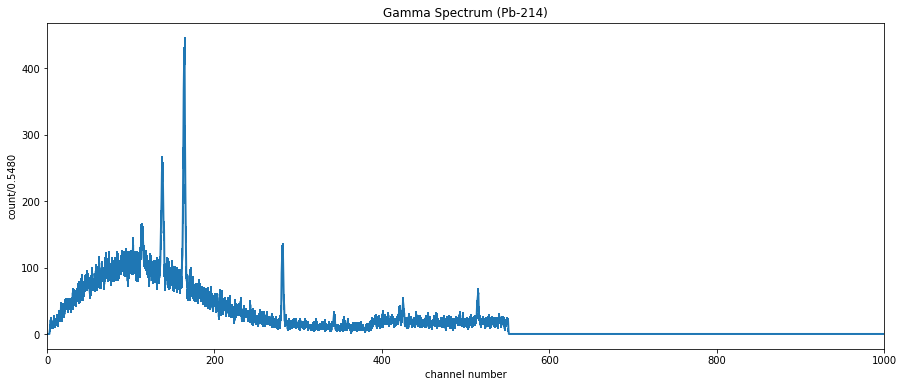

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
# For a normal histogram (without error bars) one would use:
# hist_data = ax.hist(x_data, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='Data', color='blue')
y, bin_edges = np.histogram(x_data, bins=Nbins, range=(xmin, xmax), normed=False)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
sy = np.sqrt(y)      # This is the standard for histograms - each bin is Poisson distributed!
hist_data = ax.errorbar(x, y, sy, linewidth=2, label="Data", zorder=1)
ax.set(xlabel="channel number", ylabel = "count/0.5480".format(binwidth),
       title = "Gamma Spectrum (Pb-214)", xlim=(xmin, xmax))
#ax.set(xlabel="Energy [keV]", ylabel = "Frequency / {0:1.0f} keV".format(binwidth),
#       title = "Gamma Spectrum", xlim=(xmin, xmax))
#plt.close(fig)

## $\chi^{2}$ fit:

In [19]:
chi2reg = Chi2Regression(PDFmodel_CS, x[y>0], y[y>0], sy[y>0])
if IncludeSignalInFit:
    minuit_cs = Minuit(chi2reg, pedantic=False, print_level=0, Nsig1=Nsigx1,Nsig2=Nsigx2,Nsig3=Nsigx3, mu1=mux_init1,mu2=mux_init2,mu3=mux_init3, sigma1=sigmax1,sigma2=sigmax2,sigma3=sigmax3, Nbkg1=Nbkgxh1, Nbkg2=Nbkgxh2,  tau=taux, mubkg=muxbkg_init, sigbkg=sigmaxbkg,cst=cst_init)
else:
    minuit_cs = Minuit(chi2reg, pedantic=False, print_level=0, Nbkg1=Nbkgxh1, Nbkg2=Nbkgxh2,  tau=taux, mubkg=muxbkg_init, sigbkg=sigmaxbkg,cst=cst_init)
minuit_cs.migrad()                                                         # Perform the actual fit
if (not minuit_cs.get_fmin().is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")

In [20]:
minuit_output = [minuit_cs.get_fmin(), minuit_cs.get_param_states()]       # Save the output parameters in case needed
if IncludeSignalInFit:
    csfit_Nsig1,csfit_Nsig2,csfit_Nsig3, csfit_mu1,csfit_mu2,csfit_mu3, csfit_sigma1,csfit_sigma2,csfit_sigma3, csfit_Nbkg1, csfit_Nbkg2, csfit_tau, csfit_mubkg, csfit_sigbkg, csfit_cst = minuit_cs.args  # The fitted values of the parameters
else:
    csfit_Nbkg1,csfit_Nbkg2, csfit_tau, csfit_mubkg, csfit_sigbkg, csfit_cst = minuit_cs.args

Chi2_value_cs = minuit_cs.fval                                             # The Chi2 value
NvarModel_cs = len(minuit_cs.args)
Ndof_cs = len(y[y>0]) - NvarModel_cs
ProbChi2_cs = stats.chi2.sf(Chi2_value_cs, Ndof_cs)
for name in minuit_cs.parameters:
    print("  ChiSquare Fit result: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_cs.values[name], minuit_cs.errors[name]))

  ChiSquare Fit result: Nsig1 = 373.41423 +/- 44.12889
  ChiSquare Fit result: Nsig2 = 976.99209 +/- 45.23661
  ChiSquare Fit result: Nsig3 = 1810.36592 +/- 51.55203
  ChiSquare Fit result: mu1 = 113.53668 +/- 0.19404
  ChiSquare Fit result: mu2 = 137.72769 +/- 0.06103
  ChiSquare Fit result: mu3 = 163.86045 +/- 0.03159
  ChiSquare Fit result: sigma1 = 1.39949 +/- 0.20434
  ChiSquare Fit result: sigma2 = 1.18165 +/- 0.05469
  ChiSquare Fit result: sigma3 = 1.04511 +/- 0.02947
  ChiSquare Fit result: Nbkg1 = -40458.22910 +/- 2416.92579
  ChiSquare Fit result: Nbkg2 = 71959.20901 +/- 3802.67389
  ChiSquare Fit result: tau = 151.46327 +/- 4.51105
  ChiSquare Fit result: mubkg = 74.15444 +/- 3.18872
  ChiSquare Fit result: sigbkg = 93.34046 +/- 2.01739
  ChiSquare Fit result: cst = 22.49323 +/- 0.65021


In [21]:
stats.chi2.sf(Chi2_value_cs, Ndof_cs)
#Ndof_cs
#len(y[y>0])
#len(minuit_cs.args)

7.585784807998109e-60

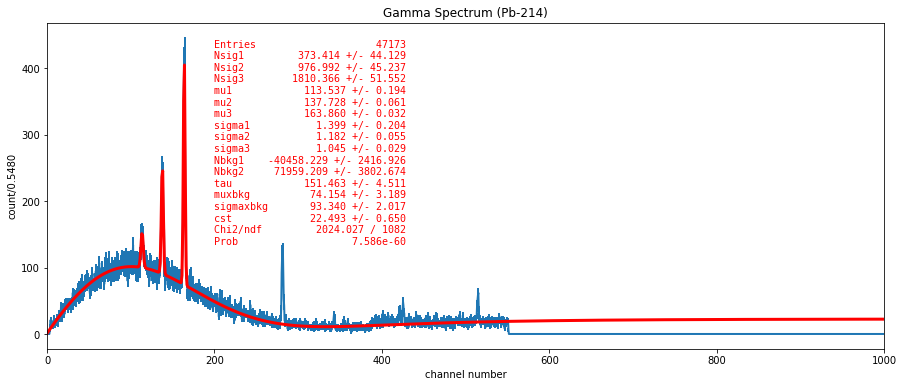

In [22]:
x_csfit = np.linspace(xmin, xmax, 1000)      # Create the x-axis for the plot of the fitted function

if IncludeSignalInFit:
    y_csfit = PDFmodel_CS(x_csfit, csfit_Nsig1,csfit_Nsig2,csfit_Nsig3, csfit_mu1,csfit_mu2,csfit_mu3, csfit_sigma1,csfit_sigma2,csfit_sigma3, csfit_Nbkg1, csfit_Nbkg2, csfit_tau, csfit_mubkg, csfit_sigbkg, csfit_cst)
else:
    y_csfit = PDFmodel_CS(x_csfit, csfit_Nbkg1, csfit_Nbkg2, csfit_tau, csfit_mubkg,  csfit_sigbkg, csfit_cst)

ax.plot(x_csfit, y_csfit, '-', color='red', linewidth=3, label='ChiSquare fit', zorder=2)


# Adding in some text (useful histogram and fit information) around the plot before showing it:
if IncludeSignalInFit:
    names = ['Entries', 'Nsig1', 'Nsig2', 'Nsig3', 'mu1','mu2','mu3', 'sigma1', 'sigma2', 'sigma3', 'Nbkg1','Nbkg2', 'tau', 'muxbkg','sigmaxbkg', 'cst', 'Chi2/ndf', 'Prob']
#    names = ['Entries', 'Nsig', 'mu1','mu2','mu3', 'sigma1', 'sigma2', 'sigma3', 'Nbkg', 'tau', 'muxbkg','sigmaxbkg' , 'Chi2/ndf', 'Prob']
    values = ["{:d}".format(len(x_data)),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['Nsig1'], minuit_cs.errors['Nsig1']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['Nsig2'], minuit_cs.errors['Nsig2']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['Nsig3'], minuit_cs.errors['Nsig3']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['mu1'], minuit_cs.errors['mu1']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['mu2'], minuit_cs.errors['mu2']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['mu3'], minuit_cs.errors['mu3']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['sigma1'], minuit_cs.errors['sigma1']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['sigma2'], minuit_cs.errors['sigma2']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['sigma3'], minuit_cs.errors['sigma3']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['Nbkg1'], minuit_cs.errors['Nbkg1']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['Nbkg2'], minuit_cs.errors['Nbkg2']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['tau'], minuit_cs.errors['tau']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['mubkg'], minuit_cs.errors['mubkg']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['sigbkg'], minuit_cs.errors['sigbkg']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['cst'], minuit_cs.errors['cst']),
              "{:.3f} / {:d}".format(Chi2_value_cs, Ndof_cs),
              "{:.3e}".format(ProbChi2_cs),
              ]
else:
    names = ['Entries', 'Nbkg1', 'Nbkg2', 'tau','mubkg','sigbkg','cst', 'Chi2/ndf', 'Prob']
    values = ["{:d}".format(len(x_data)),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['Nbkg1'], minuit_cs.errors['Nbkg1']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['Nbkg2'], minuit_cs.errors['Nbkg2']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['tau'], minuit_cs.errors['tau']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['mubkg'], minuit_cs.errors['mubkg']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['sigbkg'], minuit_cs.errors['sigbkg']),
              "{:.3f} +/- {:.3f}".format(minuit_cs.values['cst'], minuit_cs.errors['cst']),
              "{:.3f} / {:d}".format(Chi2_value_cs, Ndof_cs),
              "{:.3e}".format(ProbChi2_cs),
              ]
    
d={}
for n,v in zip(names,values):
    d[n]=v

ax.text(0.2, 0.95, nice_string_output(d, 0), family='monospace', 
        transform=ax.transAxes, fontsize=font_size, color='red', verticalalignment='top')

fig       # This prints plots the figure

## Binned Likelihood fit:

In [23]:
binned_likelihood = BinnedLH(PDFmodel_BL, x_data, bins=Nbins, bound=(xmin, xmax), extended=True)
if IncludeSignalInFit:
    minuit_bl = Minuit(binned_likelihood, pedantic=False, print_level=0, Nsig1=Nsigx1,Nsig2=Nsigx2,Nsig3=Nsigx3, mu1=mux_init1,mu2=mux_init2,mu3=mux_init3, sigma1=sigmax1,sigma2=sigmax2,sigma3=sigmax3, Nbkg1=Nbkgxh1, Nbkg2=Nbkgxh2,  tau=taux, mubkg=muxbkg_init, sigbkg=sigmaxbkg,cst=cst_init)
else:
    minuit_bl = Minuit(binned_likelihood, pedantic=False, print_level=0, Nbkg1=Nbkgxh1, Nbkg2=Nbkgxh2,  tau=taux, mubkg=muxbkg_init, sigbkg=sigmaxbkg,cst=cst_init)
minuit_bl.migrad()                                                         # Perform the actual fit
if (not minuit_bl.get_fmin().is_valid) :                                   # Check if the fit converged
    print("  WARNING: The binned likelihood fit DID NOT converge!!!")

In [24]:
minuit_output = [minuit_bl.get_fmin(), minuit_bl.get_param_states()]       # Save the output parameters in case needed
BLLH_value = minuit_bl.fval                                                # The LLH value
for name in minuit_bl.parameters:
    print("  Binned LLH Fit result: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_bl.values[name], minuit_bl.errors[name]))
    
print(f"The unbinned likelihood value was: {minuit_bl.fval:8.2f}")

  Binned LLH Fit result: Nsig1 = 290.00000 +/- nan
  Binned LLH Fit result: Nsig2 = 1000.00000 +/- nan
  Binned LLH Fit result: Nsig3 = 3000.00000 +/- nan
  Binned LLH Fit result: mu1 = 113.00000 +/- nan
  Binned LLH Fit result: mu2 = 137.00000 +/- nan
  Binned LLH Fit result: mu3 = 163.00000 +/- nan
  Binned LLH Fit result: sigma1 = 1.00000 +/- nan
  Binned LLH Fit result: sigma2 = 1.00000 +/- nan
  Binned LLH Fit result: sigma3 = 1.00000 +/- nan
  Binned LLH Fit result: Nbkg1 = 50.00000 +/- nan
  Binned LLH Fit result: Nbkg2 = 30000.00000 +/- nan
  Binned LLH Fit result: tau = 87.42119 +/- nan
  Binned LLH Fit result: mubkg = 111.00000 +/- nan
  Binned LLH Fit result: sigbkg = 40.00000 +/- nan
  Binned LLH Fit result: cst = 0.00000 +/- nan
The unbinned likelihood value was: 105025.37


In [25]:
# Plot fit result on top of histograms:
x_blfit = np.linspace(xmin, xmax, 1000)                                    # Create the x-axis for the plot of the fitted function
y_blfit = binwidth*PDFmodel_BL(x_blfit, *minuit_bl.args)
ax.plot(x_blfit, y_blfit, '-', color='green', linewidth=2, label='Binned LLH fit')

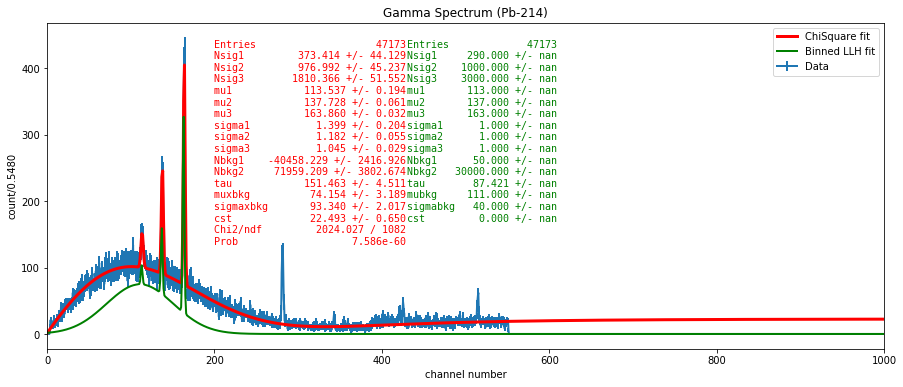

In [26]:
# Show the useful histogram and fit information:
if IncludeSignalInFit:
    names = ['Entries', 'Nsig1', 'Nsig2', 'Nsig3', 'mu1','mu2','mu3', 'sigma1', 'sigma2', 'sigma3', 'Nbkg1','Nbkg2', 'tau', 'mubkg','sigmabkg', 'cst']
    values = ["{:d}".format(len(x_data)),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['Nsig1'], minuit_bl.errors['Nsig1']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['Nsig2'], minuit_bl.errors['Nsig2']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['Nsig3'], minuit_bl.errors['Nsig3']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['mu1'], minuit_bl.errors['mu1']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['mu2'], minuit_bl.errors['mu2']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['mu3'], minuit_bl.errors['mu3']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['sigma1'], minuit_bl.errors['sigma1']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['sigma2'], minuit_bl.errors['sigma2']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['sigma3'], minuit_bl.errors['sigma3']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['Nbkg1'], minuit_bl.errors['Nbkg1']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['Nbkg2'], minuit_bl.errors['Nbkg2']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['tau'], minuit_bl.errors['tau']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['mubkg'], minuit_bl.errors['mubkg']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['sigbkg'], minuit_bl.errors['sigbkg']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['cst'], minuit_bl.errors['cst']),
              
              ]
else:
    names = ['Entries','Nbkg1','Nbkg2', 'tau', 'mubkg','sigmabkg', 'cst']
    values = ["{:d}".format(len(x_data)),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['Nbkg1'], minuit_bl.errors['Nbkg1']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['Nbkg2'], minuit_bl.errors['Nbkg2']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['tau'], minuit_bl.errors['tau']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['mubkg'], minuit_bl.errors['mubkg']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['sigbkg'], minuit_bl.errors['sigbkg']),
              "{:.3f} +/- {:.3f}".format(minuit_bl.values['cst'], minuit_bl.errors['cst']),
              ]
    
d={}
for n,v in zip(names,values):
    d[n]=v
    
ax.text(0.43, 0.95, nice_string_output(d, 0), family='monospace', 
        transform=ax.transAxes, fontsize=font_size, color='green', verticalalignment='top')
ax.legend()
fig

In [27]:
if Saveplots:
    #fig.savefig("GSFit", dpi=600)
    fig.savefig("GSFit.pdf", bbox_inches='tight')